<a href="https://colab.research.google.com/github/Amal-Baby-Mathews/Amal_TensorFlow2.0/blob/main/LSTM%7CShap%7CRetrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install shap
#!pip install pynput

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 10.9 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Reshape
from tensorflow.keras.callbacks import EarlyStopping
from shap import KernelExplainer, summary_plot,sample

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
data = pd.read_csv('/content/drive/MyDrive/Data_ML/temperory_dataset2.csv')
data = data.dropna()
X = data.drop('be_system_abort_shutdown', axis=1)
y = data['be_system_abort_shutdown']

In [6]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Reshape the input data for LSTM
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))


In [7]:
print(X.head(3))
print(y.head(3))

       be_ambient_tt_scaled_value  be_scg_n2  be_stream2methane  \
11708                   19.379999   1.198203          97.400002   
11709                   19.379999   1.198203          97.400002   
11710                   19.379999   1.198203          97.400002   

       al_productgasoutlet_temp  pdc_powermeterphasenuetral_amps  
11708                 50.312500                         0.257775  
11709                 50.296875                         0.257775  
11710                 50.312500                         0.257777  
11708    1
11709    1
11710    1
Name: be_system_abort_shutdown, dtype: int64


In [8]:
model = Sequential()
model.add(LSTM(64, input_shape=(1, X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, callbacks=[early_stop])


Epoch 1/2
14404/14404 [==============================] - 42s 3ms/step - loss: 0.0054 - accuracy: 0.9991 - val_loss: 4.5892e-11 - val_accuracy: 1.0000
Epoch 2/2
14404/14404 [==============================] - 37s 3ms/step - loss: 7.1013e-04 - accuracy: 0.9998 - val_loss: 7.4032e-14 - val_accuracy: 1.0000


In [9]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')


3601/3601 [==============================] - 4s 1ms/step - loss: 7.4032e-14 - accuracy: 1.0000
Test accuracy: 1.0


In [10]:
model_lstm = Sequential()
model_lstm.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dense(1, activation='sigmoid'))

# Create a separate model for SHAP
input_layer = Input(shape=(X_train.shape[1] * X_train.shape[2],))
reshaped = Reshape((X_train.shape[1], X_train.shape[2]))(input_layer)
output = model_lstm(reshaped)
model_shap = Model(inputs=input_layer, outputs=output)

# Compile and train the model
# ... (code omitted for brevity)

# Prepare the data for feature importance analysis
background_data = X_train.reshape(-1, X_train.shape[1] * X_train.shape[2])
background_data_summary = sample(background_data, 1)  # Use 1000 representative samples
explainer = KernelExplainer(model_shap.predict, background_data_summary)

# Downsample X_test to 5000 samples
X_test_downsampled = resample(X_test.reshape(-1, X_test.shape[1] * X_test.shape[2]),
                              replace=False,
                              n_samples=50,
                              random_state=42)

# Calculate feature importance using SHAP
shap_values = explainer.shap_values(X_test_downsampled)
#summary_plot(shap_values, X.columns)


1/1 [==============================] - 0s 363ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


In [12]:
def predict_failure(data):
    data_scaled = scaler.transform(data)
    data_reshaped = data_scaled.reshape((-1, 1,data_scaled.shape[1]))
    prediction = model.predict(data_reshaped)
    failure_probability = prediction[0][0]
    return failure_probability

# Set a threshold for failure prediction
threshold = 0.7

In [13]:
def get_latest_system_data(window_size=5,X_test=X_test):
    # Initialize a counter to keep track of the current window
    window_counter = 0
    num_features = X_test.shape[2]  # Get the number of features from X_test

    while True:
        # Calculate the start and end indices for the current window
        start = window_counter * window_size
        end = start + window_size

        # Check if we have reached the end of X_test
        if end > X_test.shape[0]:
            # Reset the counter to start from the beginning
            window_counter = 0
            start = 0
            end = window_size
            return None
        # Get the current window of data
        current_window = X_test[start:end]

        # Reshape the window to match the expected input shape
        latest_data = current_window.reshape(window_size, num_features)

        # Simulate new data by adding random noise
        noise = np.random.normal(0, 0.1, size=latest_data.shape)
        latest_data += noise

        # Increment the window counter
        window_counter += 1
        #print(latest_data)
        yield latest_data

In [36]:
def retrain_model(data,model=model,model_lstm=model_lstm):
  X = data.drop('be_system_abort_shutdown', axis=1)
  y = data['be_system_abort_shutdown']
  print(f"Data Used:{X.head()},{y.head()}")
  scaler = MinMaxScaler()
  X_scaled = scaler.fit_transform(X)

  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

  # Reshape the input data for LSTM
  X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
  X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
  early_stop = EarlyStopping(monitor='val_loss', patience=5)
  model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, callbacks=[early_stop])
  test_loss, test_acc = model.evaluate(X_test, y_test)
  print(f'Test accuracy: {test_acc}')
  # Create a separate model for SHAP
  input_layer = Input(shape=(X_train.shape[1] * X_train.shape[2],))
  reshaped = Reshape((X_train.shape[1], X_train.shape[2]))(input_layer)
  output = model_lstm(reshaped)
  model_shap = Model(inputs=input_layer, outputs=output)

  # Compile and train the model
  # ... (code omitted for brevity)

  # Prepare the data for feature importance analysis
  background_data = X_train.reshape(-1, X_train.shape[1] * X_train.shape[2])
  background_data_summary = sample(background_data, 1)  # Use 1000 representative samples
  explainer = KernelExplainer(model_shap.predict, background_data_summary)

  # Downsample X_test to 5000 samples
  X_test_downsampled = resample(X_test.reshape(-1, X_test.shape[1] * X_test.shape[2]),
                                replace=False,
                                n_samples=50,
                                random_state=42)

  # Calculate feature importance using SHAP
  shap_values = explainer.shap_values(X_test_downsampled)
  import matplotlib.pyplot as plt
  #import numpy as np  # Ensure numpy is imported for mean and std calculations

  feature_names = X.columns

  # Create a color map for better visualization
  cmap = plt.get_cmap('Blues')

  # Calculate SHAP value statistics (corrected for multi-dimensional arrays)
  shap_values_mean = np.mean(shap_values, axis=0)
  shap_values_std = np.std(shap_values, axis=0)

  # Plot SHAP values (corrected color assignment using a loop)
  plt.figure(figsize=(12, 8))
  for i in range(len(feature_names)):
      color = cmap(i / len(feature_names))  # Assign varying colors for better visualization
      plt.bar(i, shap_values_mean[i], yerr=shap_values_std[i], capsize=5, color=color, edgecolor='black')

  plt.xticks(range(len(feature_names)), feature_names, rotation=90)
  plt.xlabel('Feature')
  plt.ylabel('SHAP Value')
  plt.title('SHAP Value Distribution +SHAP value indicate that particular field is more likely to have caused the failure in the system')
  plt.tight_layout()
  plt.show()
  return model,shap_values

In [37]:
def get_latest_train_data(window_size=1000,data=data_new):
    data = data.dropna()
    # Loop through the data in windows
    for i in range(0, len(X), window_size):
      end_index = min(i + window_size, len(X))  # Ensure end doesn't exceed data length
      new_data = data[i:end_index]
      yield new_data

In [38]:
data_new = pd.read_csv('/content/drive/MyDrive/Data_ML/temperory_dataset.csv')


[0.46631082 0.23880322 0.88856505 0.09442293 0.75224561]
1/1 [==============================] - 0s 18ms/step
Data Used:   be_ambient_tt_scaled_value  be_scg_n2  be_stream2methane  \
0                   20.430000   0.727123          97.119904   
1                   20.440001   0.727123          97.119904   
2                   20.440001   0.727123          97.119904   
3                   20.450001   0.727123          97.119904   
4                   20.450001   0.727123          97.119904   

   al_productgasoutlet_temp  pdc_powermeterphasenuetral_amps  
0                    80.125                         6.941713  
1                    80.125                         6.941651  
2                    80.125                         6.973380  
3                    80.125                         6.972971  
4                    80.125                         6.972627  ,0    0
1    0
2    0
3    0
4    0
Name: be_system_abort_shutdown, dtype: int64
Epoch 1/2
 1/25 [>..........................

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


25/25 [==============================] - 0s 5ms/step - loss: 1.5158e-05 - accuracy: 1.0000 - val_loss: 1.9870e-06 - val_accuracy: 1.0000
Epoch 2/2
7/7 [==============================] - 0s 2ms/step - loss: 1.8718e-06 - accuracy: 1.0000
Test accuracy: 1.0
1/1 [==============================] - 0s 301ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


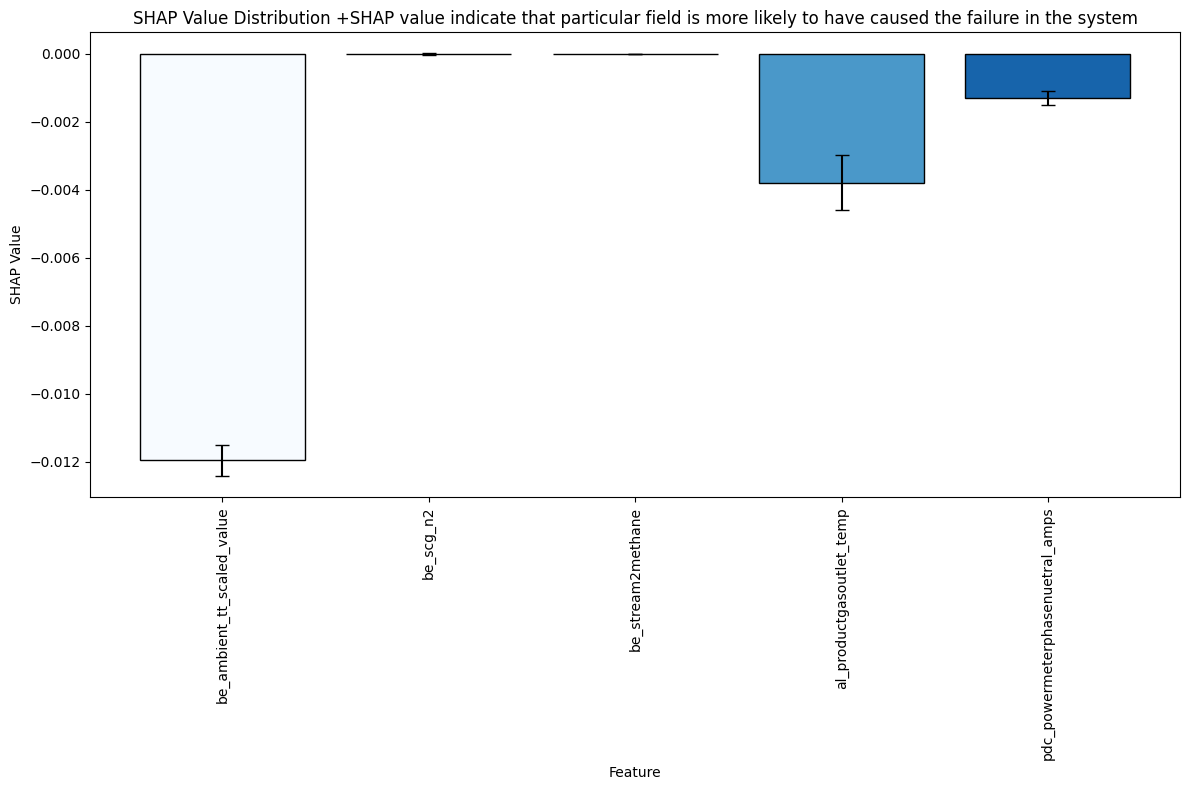

System operating normally.
[ 0.50124009 -0.12902632  0.55462386  0.47615564  1.00458576]
1/1 [==============================] - 0s 16ms/step
Data Used:      be_ambient_tt_scaled_value  be_scg_n2  be_stream2methane  \
1000                       20.40   0.730086          97.119904   
1001                       20.40   0.730086          97.119904   
1002                       20.41   0.730086          97.119904   
1003                       20.41   0.730086          97.119904   
1004                       20.41   0.730086          97.119904   

      al_productgasoutlet_temp  pdc_powermeterphasenuetral_amps  
1000                 79.890625                         6.845855  
1001                 79.906250                         6.845877  
1002                 79.890625                         6.845842  
1003                 79.906250                         6.845841  
1004                 79.890625                         6.845852  ,1000    0
1001    0
1002    0
1003    0
1004    0
Name: 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


25/25 [==============================] - 0s 6ms/step - loss: 7.6729e-04 - accuracy: 1.0000 - val_loss: 9.6694e-04 - val_accuracy: 1.0000
Epoch 2/2
7/7 [==============================] - 0s 2ms/step - loss: 4.4846e-04 - accuracy: 1.0000
Test accuracy: 1.0
1/1 [==============================] - 0s 307ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


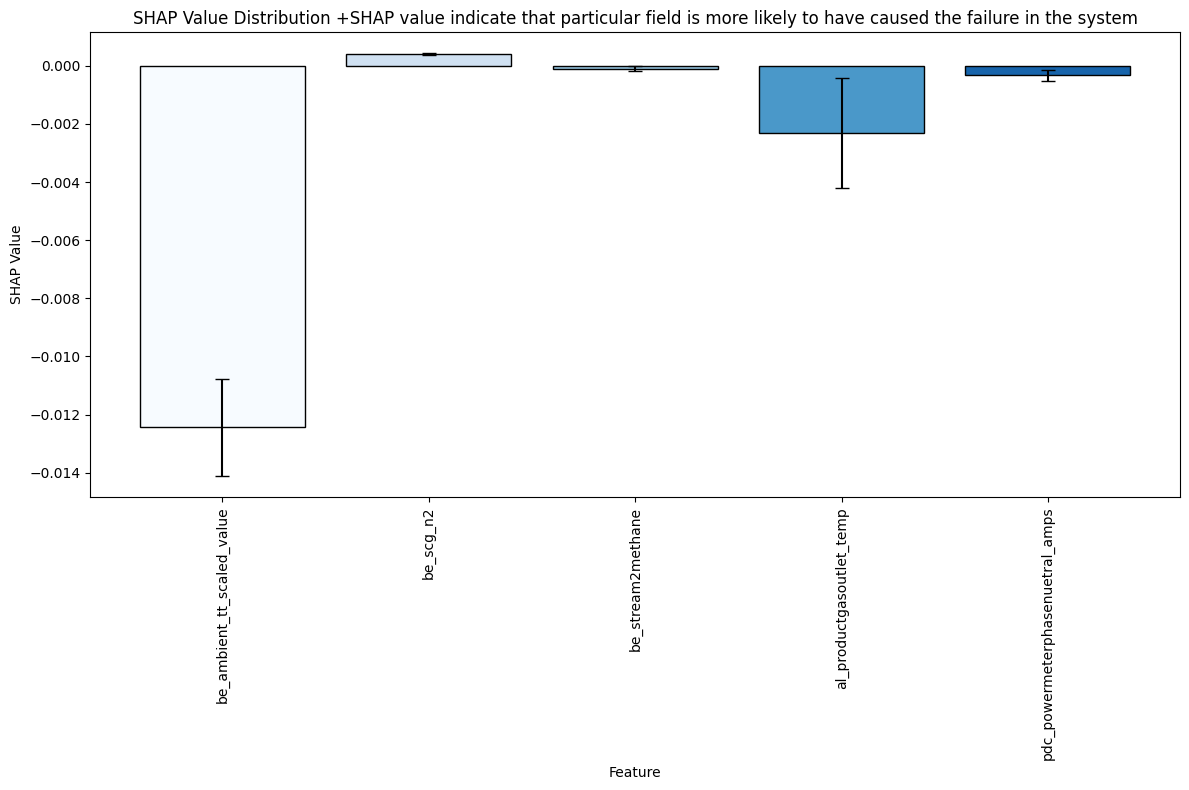

System operating normally.
[0.84106461 0.39245318 0.21930385 1.03726759 1.10081205]
1/1 [==============================] - 0s 16ms/step
Data Used:      be_ambient_tt_scaled_value  be_scg_n2  be_stream2methane  \
2002                       20.51   0.726923          97.129997   
2003                       20.51   0.726923          97.129997   
2004                       20.51   0.726923          97.129997   
2005                       20.51   0.726923          97.129997   
2006                       20.51   0.726923          97.129997   

      al_productgasoutlet_temp  pdc_powermeterphasenuetral_amps  
2002                 79.890625                         6.882309  
2003                 79.875000                         6.914315  
2004                 79.890625                         6.914275  
2005                 79.875000                         6.914276  
2006                 79.859375                         6.914277  ,2002    0
2003    0
2004    0
2005    0
2006    0
Name: be_sy

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


25/25 [==============================] - 0s 6ms/step - loss: 0.0032 - accuracy: 0.9987 - val_loss: 1.9194e-18 - val_accuracy: 1.0000
Epoch 2/2
7/7 [==============================] - 0s 2ms/step - loss: 1.4282e-18 - accuracy: 1.0000
Test accuracy: 1.0
1/1 [==============================] - 0s 291ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


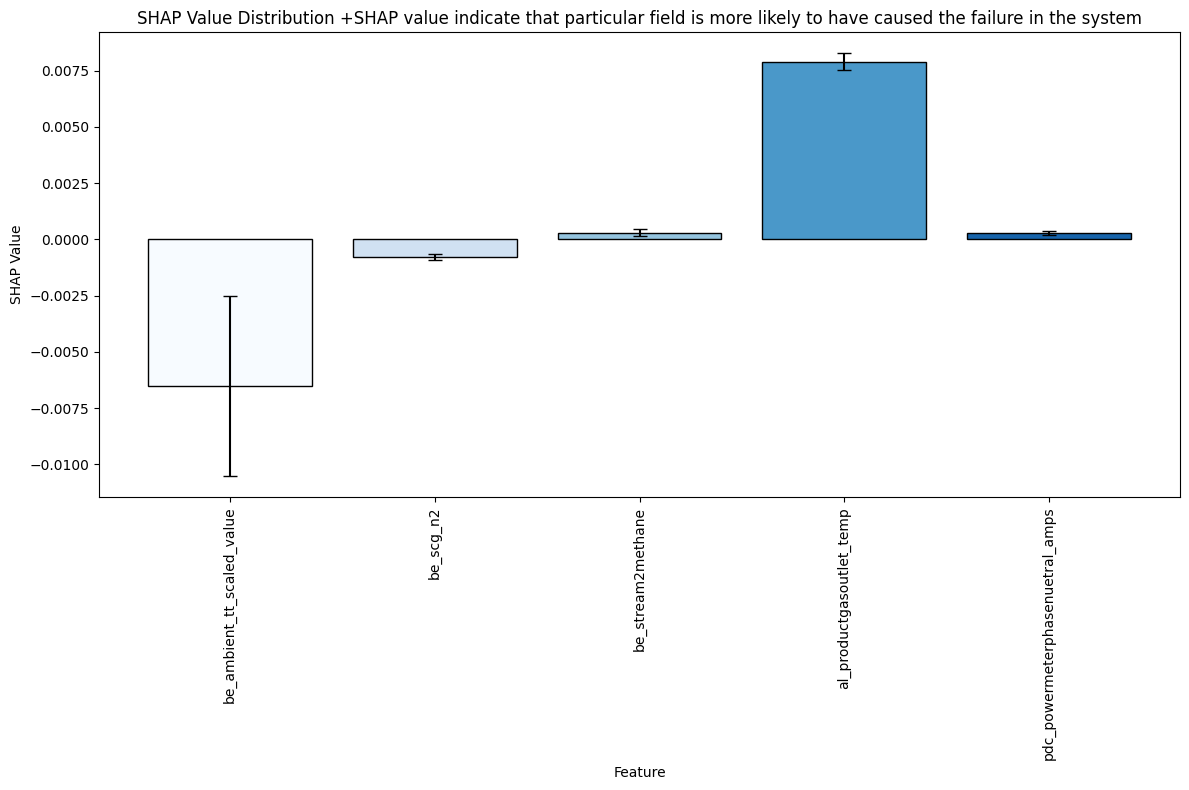

System operating normally.
[0.54136081 0.25057691 0.62582925 1.08929407 1.27995565]
1/1 [==============================] - 0s 16ms/step
Data Used:      be_ambient_tt_scaled_value  be_scg_n2  be_stream2methane  \
3003                   20.950001   0.730722          97.119904   
3004                   20.930000   0.730722          97.119904   
3005                   20.940001   0.730722          97.119904   
3006                   20.930000   0.730722          97.119904   
3007                   20.950001   0.730722          97.119904   

      al_productgasoutlet_temp  pdc_powermeterphasenuetral_amps  
3003                     80.25                         7.072748  
3004                     80.25                         7.072728  
3005                     80.25                         7.040709  
3006                     80.25                         7.040648  
3007                     80.25                         7.040607  ,3003    0
3004    0
3005    0
3006    0
3007    0
Name: be_sy

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


25/25 [==============================] - 0s 6ms/step - loss: 3.1899e-05 - accuracy: 1.0000 - val_loss: 4.2624e-15 - val_accuracy: 1.0000
Epoch 2/2
7/7 [==============================] - 0s 2ms/step - loss: 3.9835e-15 - accuracy: 1.0000
Test accuracy: 1.0
1/1 [==============================] - 0s 311ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


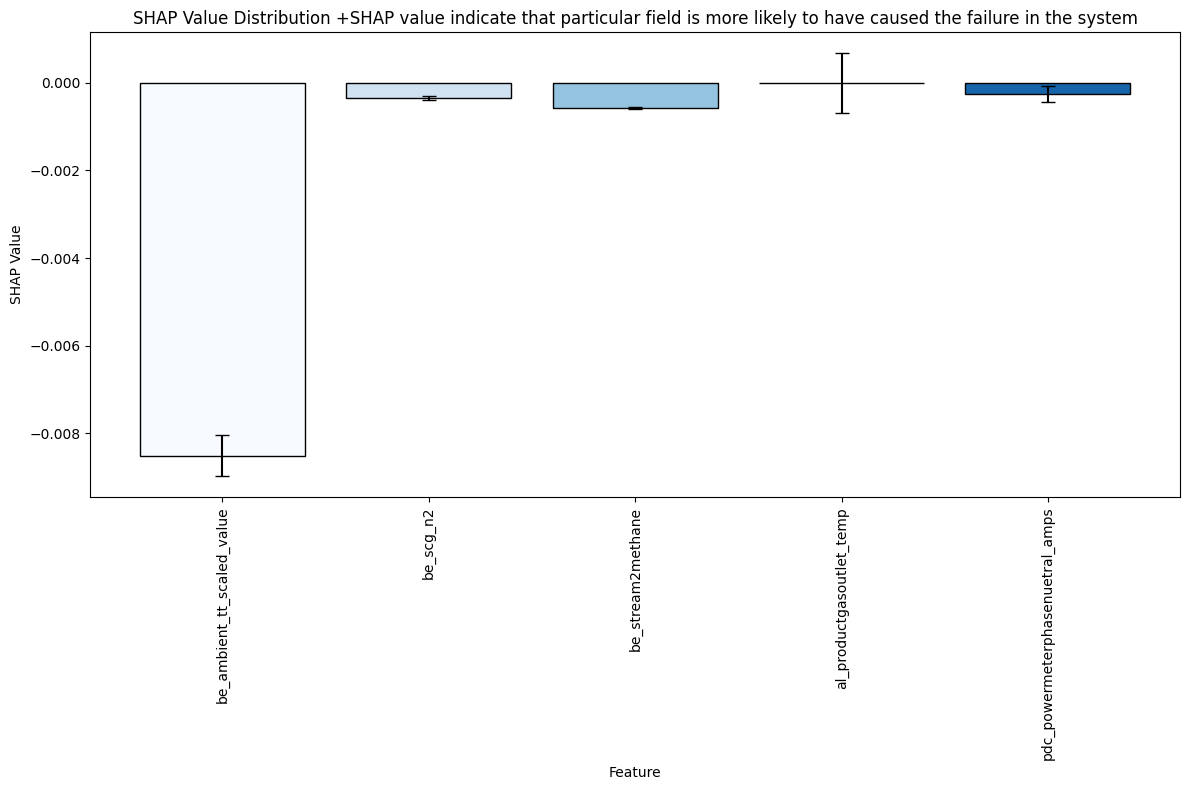

System operating normally.
[0.80530393 0.13786045 0.55073953 0.75353454 0.99097165]
1/1 [==============================] - 0s 15ms/step
Data Used:      be_ambient_tt_scaled_value  be_scg_n2  be_stream2methane  \
4004                   20.430000   0.734884          97.129997   
4005                   20.430000   0.734884          97.129997   
4006                   20.430000   0.734884          97.129997   
4007                   20.440001   0.734884          97.129997   
4008                   20.430000   0.734884          97.129997   

      al_productgasoutlet_temp  pdc_powermeterphasenuetral_amps  
4004                 80.062500                         6.818942  
4005                 80.062500                         6.818978  
4006                 80.062500                         6.818914  
4007                 80.062500                         6.818872  
4008                 80.078125                         6.786849  ,4004    0
4005    0
4006    0
4007    0
4008    0
Name: be_sy

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


25/25 [==============================] - 0s 6ms/step - loss: 1.8447e-06 - accuracy: 1.0000 - val_loss: 5.0951e-07 - val_accuracy: 1.0000
Epoch 2/2
7/7 [==============================] - 0s 2ms/step - loss: 5.0767e-07 - accuracy: 1.0000
Test accuracy: 1.0
1/1 [==============================] - 0s 293ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


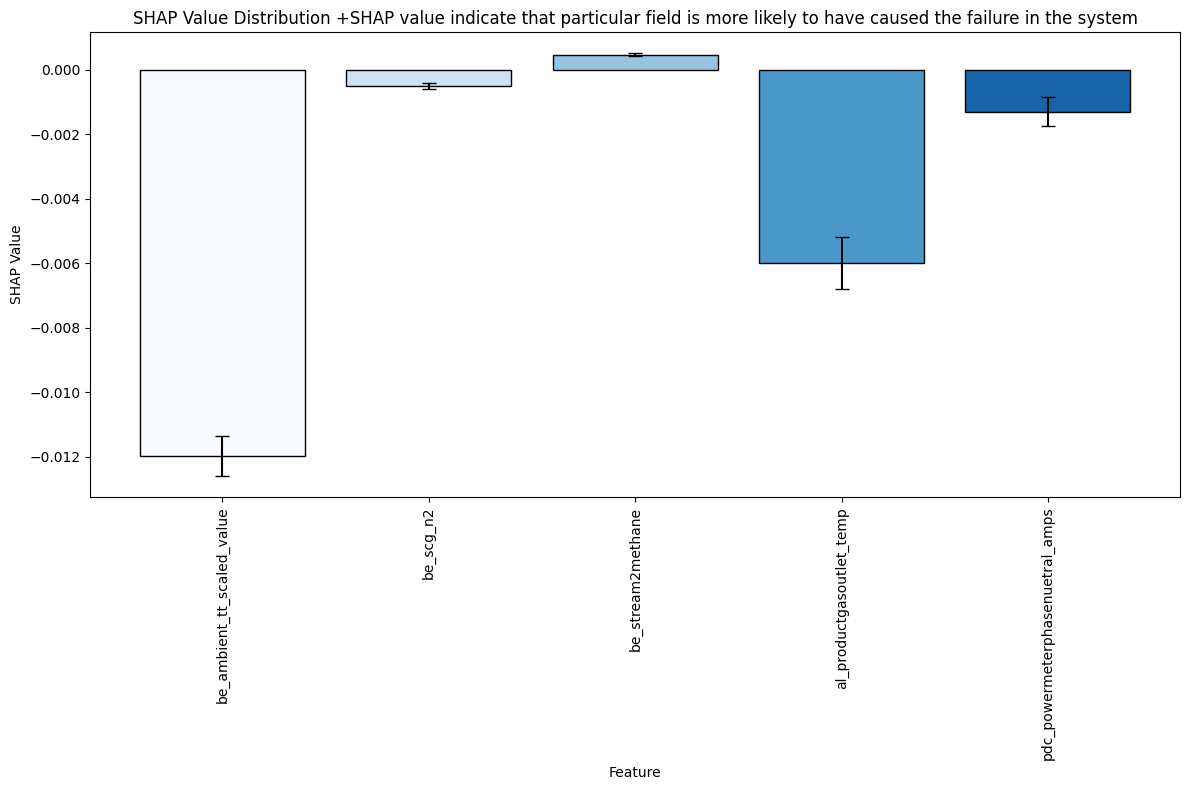

System operating normally.
[0.71257282 0.07159688 0.51838961 0.89859687 0.813119  ]
1/1 [==============================] - 0s 15ms/step
Data Used:      be_ambient_tt_scaled_value  be_scg_n2  be_stream2methane  \
5006                   20.360001   0.749221          97.119904   
5007                   20.370001   0.749221          97.119904   
5008                   20.379999   0.749221          97.119904   
5009                   20.379999   0.749221          97.119904   
5010                   20.379999   0.749221          97.119904   

      al_productgasoutlet_temp  pdc_powermeterphasenuetral_amps  
5006                 79.937500                         7.008947  
5007                 79.921875                         7.008844  
5008                 79.937500                         7.008776  
5009                 79.921875                         7.008708  
5010                 79.921875                         7.008615  ,5006    0
5007    0
5008    0
5009    0
5010    0
Name: be_sy

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


25/25 [==============================] - 0s 6ms/step - loss: 3.0363e-12 - accuracy: 1.0000 - val_loss: 2.1967e-05 - val_accuracy: 1.0000
Epoch 2/2
7/7 [==============================] - 0s 2ms/step - loss: 2.1963e-05 - accuracy: 1.0000
Test accuracy: 1.0
1/1 [==============================] - 0s 324ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


Exception ignored in: <function _xla_gc_callback at 0x782b66d19fc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


1/1 [==============================] - 0s 24ms/step


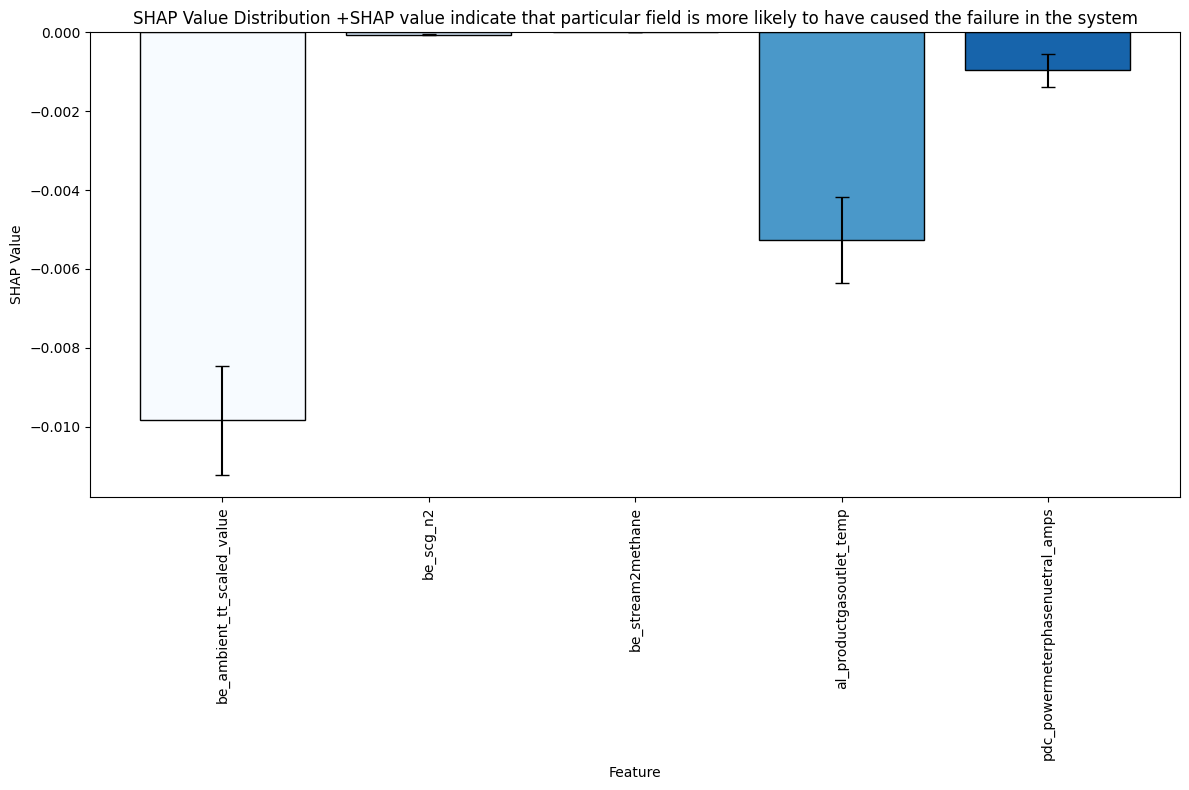

System operating normally.
[0.69296155 0.40686537 0.4793568  0.81014715 1.05228983]
1/1 [==============================] - 0s 26ms/step
Data Used:      be_ambient_tt_scaled_value  be_scg_n2  be_stream2methane  \
6006                       20.52     0.7577          97.119904   
6007                       20.51     0.7577          97.119904   
6008                       20.51     0.7577          97.119904   
6009                       20.50     0.7577          97.119904   
6010                       20.51     0.7577          97.119904   

      al_productgasoutlet_temp  pdc_powermeterphasenuetral_amps  
6006                 79.734375                         6.910090  
6007                 79.734375                         6.910109  
6008                 79.734375                         6.878096  
6009                 79.734375                         6.878086  
6010                 79.734375                         6.878037  ,6006    0
6007    0
6008    0
6009    0
6010    0
Name: be_sy

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


25/25 [==============================] - 0s 8ms/step - loss: 1.0531e-08 - accuracy: 1.0000 - val_loss: 9.6158e-18 - val_accuracy: 1.0000
Epoch 2/2
7/7 [==============================] - 0s 2ms/step - loss: 9.6156e-18 - accuracy: 1.0000
Test accuracy: 1.0


KeyboardInterrupt: 

In [40]:
data_generator = get_latest_system_data(window_size=5)  # Set the desired window size
trainer_generator=get_latest_train_data(window_size=1000,data=data_new)

while True:
  # Get the latest system data
  latest_data = next(data_generator)
  print(latest_data[0])
  # Predict failure probability
  failure_prob = predict_failure(latest_data)
  new_data = next(trainer_generator)
  model,shap_values=retrain_model(new_data)
  if failure_prob > threshold:
      print(f'Potential system failure detected! Probability: {failure_prob:.2f}')
      print('Field variations contributing to the failure:')
      for feature, importance_list in zip(X.columns, shap_values[0].tolist()):
            for importance in importance_list:
                if importance > 0:
                    #if abs(importance) > 0.001:  # Print only if the absolute SHAP value is greater than 0.001
                    print(f'- {feature}: Importance = {"{}".format(importance)}')
      break

  else:
      print('System operating normally.')
